In [1]:
## Module import
## re, gensim, spacy for processing text
## pyLDAvis, matplolib for visualization
## numpy, pandas for manipulating and viewing data

In [2]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('top_news.csv', index_col=0)

In [4]:
df.head()

,content,date,ticker,title
0,One big shareholder in Twenty-First Century Fo...,2018-06-28,FOX,Fox shareholder urges hearing out Comcast coun...
1,Disney and Twenty-First Century Fox have a def...,2018-06-28,DIS,"Disney, Fox set July 27 vote on $71B asset deal"
2,Disney and Twenty-First Century Fox have a def...,2018-06-28,DIS,"Disney, Fox set July 27 vote on $71B asset deal"
3,Stocks reclaimed around a third of their losse...,2018-06-28,NaN,"Stocks trim week's losses as bank, tech stocks..."
4,One big shareholder in Twenty-First Century Fo...,2018-06-28,FOX,Fox shareholder urges hearing out Comcast coun...


In [5]:
# drop duplicate news
df = df.drop_duplicates(['content', 'title'])
df = df.reset_index(drop=True)

In [6]:
df['title'][2]

"Stocks trim week's losses as bank, tech stocks rebound"

In [7]:
# Tokenize and clean-up text
def news_to_words(news): return gensim.utils.simple_preprocess(str(news), deacc=True)

In [8]:
df['content_title'] = df['title'] + '. ' + df['content']
content_title_array = list(df['content_title'].apply(lambda x: news_to_words(x)))

In [9]:
# Lemmatization
def lemmatization(news_array, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    news_out = []
    for news_tokens in news_array:
        news_obj = nlp(' '.join(news_tokens))
        news_out.append(' '.join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in news_obj if token.pos_ in allowed_postags]))
    return news_out

In [10]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', diable=['parser', 'ner'])

/home/data/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/data/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/home/data/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/data/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/data/a

/home/data/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/data/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/home/data/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/home/data/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/home/data/anaconda3/lib/python3

In [11]:
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(content_title_array)

In [13]:
data_lemmatized[:2]

['fox shareholder urge hear comcast counter offer big shareholder first century fox be urge rupert murdoch give comcast chance fox seemingly barrel closing agreement sell  medium asset disney fund management want hear counter offer reuter report hedge fund own fox share be strongly motivated support whichev deal come big price that mean disagree murdoch stance comcast offer which late have be superior absolute value would come high regulatory risk justice dept have already sign disney agreement',
 'disney fox set vote asset deal disney first century fox have definitive proxy set shareholder vote  asset deal that will take place special meeting company take place day hilton new york record date stockholder who can vote be may move next step now accelerate process move entertainment asset disney comcast thought be take  time potential counter offer be now back clock vote date loom previously fox shareholder urge hear comcast counter offer previously disney comcast war also mean hulu cust

In [12]:
# create document-word matrix
vectorizer = CountVectorizer(analyzer='word',
                            min_df=10,
                            stop_words='english',
                            lowercase=True,
                            token_pattern='[a-zA-Z0-9]{3,}')

In [14]:
text_vectorized = vectorizer.fit_transform(data_lemmatized)

In [15]:
text_dense = text_vectorized.todense()

In [16]:
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((text_dense > 0).sum()/text_dense.size)*100, "%")

Sparsicity:  0.7877793088444914 %


In [17]:
# build LDA model with sklearn
lda_model = LatentDirichletAllocation(n_topics=10, 
                                     max_iter=10, 
                                     learning_method='online',
                                     random_state=100,
                                     batch_size=128,
                                     evaluate_every=-1,
                                     n_jobs=-1)

In [18]:
lda_output = lda_model.fit_transform(text_vectorized)

/home/data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [19]:
print(lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=10, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [20]:
# diagnose model performance
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(text_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(text_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -5269576.297429561
Perplexity:  1114.6312808581126
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 10,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [21]:
# Grid search

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(text_vectorized)

/home/data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'bat

/home/data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/data/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'bat

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
# see the best topic model and its parameters
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(text_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -1857717.637834459
Model Perplexity:  1050.3418335659837


/home/data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


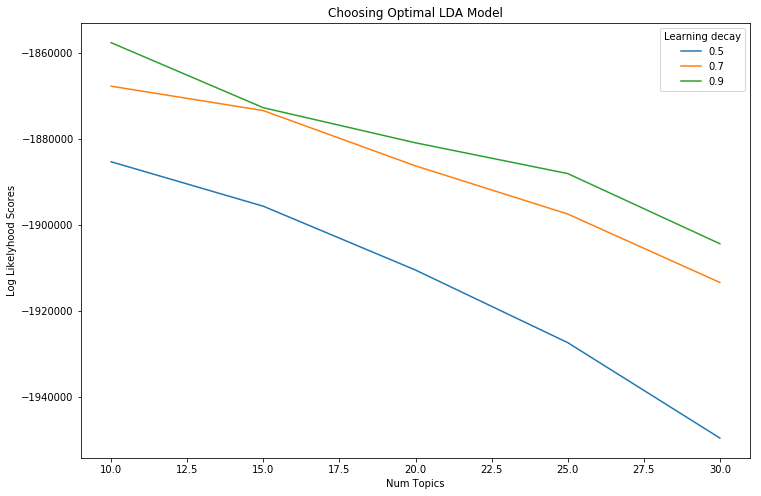

In [23]:
# compare different model and visualization

# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [24]:
# See dominant topic in each document

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(text_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(content_title_array))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0,0,0,0,0.04,0,0,0.03,0,0.93,9
1,0,0,0,0,0,0,0,0,0,0.99,9
2,0,0.83,0.04,0,0,0.04,0,0,0,0.09,1
3,0,0.06,0.22,0,0,0.45,0,0,0,0.25,5
4,0,0,0.74,0,0.25,0,0,0,0,0,2
5,0,0.33,0,0,0.21,0,0,0,0.16,0.28,1
6,0,0,0,0,0,0,0,0,0,0.98,9
7,0,0.02,0,0,0.08,0.02,0,0,0,0.88,9
8,0,0.74,0,0.03,0,0,0,0,0.15,0.06,1
9,0,0.99,0,0,0,0,0,0,0,0,1


In [25]:
topic_eight_index = df_document_topic[df_document_topic['dominant_topic'] == 8].index.values

In [26]:
df.iloc[topic_eight_index].head()

,content,date,ticker,title,content_title
34,Chinese markets are leading losses across the ...,2018-06-19,SPY,Trade war: China leads world markets lower,Trade war: China leads world markets lower. Ch...
36,"""The Chinese view this as an exercise in self-...",2018-06-18,SPY,Futures drop amid trade war fears,"Futures drop amid trade war fears. ""The Chines..."
106,Back on? The White House is proceeding with it...,2018-05-30,FXI,U.S. moves forward with China tariffs,U.S. moves forward with China tariffs. Back on...
115,Despite what the government over the weekend s...,2018-05-29,EWZ,Brazil set for more losses as truck strike con...,Brazil set for more losses as truck strike con...
124,The Trump Administration is now telling Congre...,2018-05-25,ZTCOF,NYT: Trump admin telling Congress it has deal ...,NYT: Trump admin telling Congress it has deal ...


In [27]:
# review topic distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,2654
1,2,2291
2,9,2170
3,1,1990
4,6,1676
5,4,957
6,0,940
7,7,926
8,8,708
9,3,233


In [28]:
# visualize LDA model with pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, text_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      18.218111        1       1  156.318741   52.555466
2      15.178398        1       2 -127.438492 -137.534286
9      13.257434        1       3 -491.695282  -77.336494
5      11.048438        1       4 -244.126068 -463.175964
6      10.625256        1       5  188.031128 -357.083496
0       7.764894        1       6 -150.186386  203.454651
4       7.618792        1       7  308.369476  377.409882
7       6.806358        1       8  487.929474  -53.860020
8       6.553817        1       9  -59.467045  546.243286
3       2.928503        1      10 -476.046509  335.352234, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
4089  Default  2713.000000        sale  2713.000000  30.0000  30.0000
767   Default  2484.000000       china  2484.000000  29.0000  29.0000
3245  Default  3500.000000         oil  3500.000000  28.0000  28.0000
4510  Default  6926.000000       stock  6926.000000  27.0000  27.0000
3767  Default  3255.000000        rate  3255.000000  26.0000  26.0000
979   Default  2099.000000   consensus  2099.000000  25.0000  25.0000
1185  Default  3381.000000        deal  3381.000000  24.0000  24.0000
1972  Default  3409.000000      future  3409.000000  23.0000  23.0000
3978  Default  1938.000000     revenue  1938.000000  22.0000  22.0000
3604  Default  1804.000000       prior  1804.000000  21.0000  21.0000
5282  Default  3283.000000       yield  3283.000000  20.0000  20.0000
1639  Default  2825.000000        etfs  2825.000000  19.0000  19.0000
4840  Default  2576.000000    treasury  2576.000000  18.0000  18.0000
918   Default  3911.000000     company  3911.000000  17.0000  17.0000
1111  Default  1870.000000       crude  1870.000000  16.0000  16.0000
1705  Default  3696.000000      expect  3696.000000  15.0000  15.0000
1990  Default  2972.000000        gain  2972.000000  14.0000  14.0000
1805  Default  1223.000000        feed  1223.000000  13.0000  13.0000
768   Default   943.000000     chinese   943.000000  12.0000  12.0000
4448  Default   841.000000         spy   841.000000  11.0000  11.0000
2095  Default  2168.000000      growth  2168.000000  10.0000  10.0000
4165  Default  1957.000000      sector  1957.000000   9.0000   9.0000
2365  Default  2482.000000       index  2482.000000   8.0000   8.0000
2509  Default   820.000000         ivv   820.000000   7.0000   7.0000
4446  Default   820.000000        spxu   820.000000   6.0000   6.0000
4457  Default   820.000000         sso   820.000000   5.0000   5.0000
390   Default  2986.000000        bank  2986.000000   4.0000   4.0000
2057  Default  1337.000000        gold  1337.000000   3.0000   3.0000
5114  Default   817.000000         voo   817.000000   2.0000   2.0000
4996  Default   817.000000        upro   817.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
4722  Topic10   218.372248       tesla   232.641800   3.4674  -4.6123
670   Topic10   225.964825         car   241.310854   3.4650  -4.5782
338   Topic10   172.830813        auto   185.751429   3.4586  -4.8462
2147  Topic10   169.988063    hardware   184.672314   3.4478  -4.8628
4587  Topic10    76.410907   sunedison    80.362201   3.4803  -5.6624
1998  Topic10   250.928828        game   283.413030   3.4089  -4.4734
3063  Topic10    84.165667       motor    89.070703   3.4740  -5.5658
855   Topic10    78.987819        coal    84.455401   3.4637  -5.6293
3382  Topic10   147.288556      patent   168.813839   3.3943  -5.0062
4376  Topic10   158.182544        sony   185.316495   3.3724  -4.9348
501   Topic10   163.143564      boeing   195.554885   3.3495  -4.9039
121   Topic10    83.563452    aircraft    94.646361   3.4061  -5.5729
2636  Topic10    76.064662        king    85.232686   3.4169  -5.6670
4365  Topic10   187.461856    software   

In [29]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aal,aapl,aaxj,abandon,abate,abbott,abbvie,abc,abe,...,zhou,zion,zirp,zlrg,zone,zoom,zroz,zte,zuckerberg,zynga
Topic0,0.100384,0.101326,0.104066,0.100430,0.100461,0.100483,35.568449,0.100400,0.100420,0.120459,...,0.100309,0.100980,0.100901,0.100511,1.201729,0.101141,0.101195,0.119512,0.357298,0.100861
Topic1,0.100406,0.102634,0.101850,0.103074,7.716969,7.053932,0.105292,31.444940,0.150244,0.100547,...,0.100453,0.123568,0.100403,0.100645,11.967566,0.100603,0.100485,0.112053,0.100529,0.100347
Topic2,0.141530,4.134397,16.577918,0.100646,7.585967,0.116839,0.100579,0.114275,0.101628,0.100464,...,0.100439,2.556141,0.103558,0.100408,3.663375,13.588235,0.102693,31.822976,83.478019,0.100566
Topic3,0.100419,7.704864,0.102266,0.100477,0.128407,0.100421,0.102006,0.100497,0.101127,0.100771,...,0.100305,0.167387,0.100428,0.100446,1.701677,0.101268,0.100371,0.100459,0.103621,52.078068
Topic4,30.048362,0.100422,0.100635,0.100400,13.335338,0.101378,0.100749,0.100431,11.652952,0.100405,...,0.101530,0.167189,0.101089,0.100398,0.101150,0.101852,0.100384,0.187198,0.101401,0.102334


In [33]:
# Get the top 15 keywords each topic
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,future,year,stock,yield,spy,etfs,ivv,spxu,sso,voo,upro,rsp,dia,qqq,dog
Topic 1,stock,high,year,gain,market,yield,sector,day,low,fall,share,week,oil,treasury,dow
Topic 2,say,bank,company,apple,plan,report,new,year,facebook,target,market,price,launch,include,make
Topic 3,sale,otcpk,game,car,tesla,bitcoin,dividend,software,otc,auto,hardware,solar,boeing,sony,vehicle
Topic 4,say,government,verizon,sprint,vote,debt,mobile,deal,house,president,fcc,today,new,rule,greece
Topic 5,consensus,revenue,expect,prior,year,growth,sale,rise,profit,service,fall,net,claim,price,index
Topic 6,rate,year,feed,hike,fed,bank,inflation,policy,market,expect,low,say,job,yield,fomc
Topic 7,oil,etfs,crude,output,euro,opec,price,ukraine,russia,barrel,japan,sco,uco,usl,dbo
Topic 8,china,chinese,trade,etfs,export,bank,ewh,shanghai,year,import,fxi,market,mchi,gxc,pgj
Topic 9,deal,company,share,report,say,ceo,offer,talk,disney,time,buy,previously,bid,acquire,sell


In [35]:
# predict the topics for a new piece of text

# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(news_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['future', 'year', 'stock', 'yield', 'spy', 'etfs', 'ivv', 'spxu', 'sso', 'voo', 'upro', 'rsp', 'dia', 'qqq', 'dog']


In [37]:
from sklearn.externals import joblib

In [38]:
filename = 'finalized_model.sav'
joblib.dump(lda_model, filename)

['finalized_model.sav']

In [39]:
# load the model from disk
loaded_model = joblib.load(filename)

In [40]:
loaded_model.score

<bound method LatentDirichletAllocation.score of LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=10, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)>